# Position and angle at injection BTP with real points

In [82]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from numpy import linalg as LA
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.style.use('ggplot')

In [83]:
from matplotlib.patches import Arc
from matplotlib.transforms import IdentityTransform, TransformedBbox, Bbox

class AngleAnnotation(Arc):
    """
    Draws an arc between two vectors which appears circular in display space.
    """
    def __init__(self, xy, p1, p2, size=75, unit="points", ax=None,
                 text="", textposition="inside", text_kw=None, **kwargs):
        """
        Parameters
        ----------
        xy, p1, p2 : tuple or array of two floats
            Center position and two points. Angle annotation is drawn between
            the two vectors connecting *p1* and *p2* with *xy*, respectively.
            Units are data coordinates.

        size : float
            Diameter of the angle annotation in units specified by *unit*.

        unit : str
            One of the following strings to specify the unit of *size*:

            * "pixels": pixels
            * "points": points, use points instead of pixels to not have a
              dependence on the DPI
            * "axes width", "axes height": relative units of Axes width, height
            * "axes min", "axes max": minimum or maximum of relative Axes
              width, height

        ax : `matplotlib.axes.Axes`
            The Axes to add the angle annotation to.

        text : str
            The text to mark the angle with.

        textposition : {"inside", "outside", "edge"}
            Whether to show the text in- or outside the arc. "edge" can be used
            for custom positions anchored at the arc's edge.

        text_kw : dict
            Dictionary of arguments passed to the Annotation.

        **kwargs
            Further parameters are passed to `matplotlib.patches.Arc`. Use this
            to specify, color, linewidth etc. of the arc.

        """
        self.ax = ax or plt.gca()
        self._xydata = xy  # in data coordinates
        self.vec1 = p1
        self.vec2 = p2
        self.size = size
        self.unit = unit
        self.textposition = textposition

        super().__init__(self._xydata, size, size, angle=0.0,
                         theta1=self.theta1, theta2=self.theta2, **kwargs)

        self.set_transform(IdentityTransform())
        self.ax.add_patch(self)

        self.kw = dict(ha="center", va="center",
                       xycoords=IdentityTransform(),
                       xytext=(0, 0), textcoords="offset points",
                       annotation_clip=True)
        self.kw.update(text_kw or {})
        self.text = ax.annotate(text, xy=self._center, **self.kw)

    def get_size(self):
        factor = 1.
        if self.unit == "points":
            factor = self.ax.figure.dpi / 72.
        elif self.unit[:4] == "axes":
            b = TransformedBbox(Bbox.from_bounds(0, 0, 1, 1),
                                self.ax.transAxes)
            dic = {"max": max(b.width, b.height),
                   "min": min(b.width, b.height),
                   "width": b.width, "height": b.height}
            factor = dic[self.unit[5:]]
        return self.size * factor

    def set_size(self, size):
        self.size = size

    def get_center_in_pixels(self):
        """return center in pixels"""
        return self.ax.transData.transform(self._xydata)

    def set_center(self, xy):
        """set center in data coordinates"""
        self._xydata = xy

    def get_theta(self, vec):
        vec_in_pixels = self.ax.transData.transform(vec) - self._center
        return np.rad2deg(np.arctan2(vec_in_pixels[1], vec_in_pixels[0]))

    def get_theta1(self):
        return self.get_theta(self.vec1)

    def get_theta2(self):
        return self.get_theta(self.vec2)

    def set_theta(self, angle):
        pass

    # Redefine attributes of the Arc to always give values in pixel space
    _center = property(get_center_in_pixels, set_center)
    theta1 = property(get_theta1, set_theta)
    theta2 = property(get_theta2, set_theta)
    width = property(get_size, set_size)
    height = property(get_size, set_size)

    # The following two methods are needed to update the text position.
    def draw(self, renderer):
        self.update_text()
        super().draw(renderer)

    def update_text(self):
        c = self._center
        s = self.get_size()
        angle_span = (self.theta2 - self.theta1) % 360
        angle = np.deg2rad(self.theta1 + angle_span / 2)
        r = s / 2
        if self.textposition == "inside":
            r = s / np.interp(angle_span, [60, 90, 135, 180],
                                          [3.3, 3.5, 3.8, 4])
        self.text.xy = c + r * np.array([np.cos(angle), np.sin(angle)])
        if self.textposition == "outside":
            def R90(a, r, w, h):
                if a < np.arctan(h/2/(r+w/2)):
                    return np.sqrt((r+w/2)**2 + (np.tan(a)*(r+w/2))**2)
                else:
                    c = np.sqrt((w/2)**2+(h/2)**2)
                    T = np.arcsin(c * np.cos(np.pi/2 - a + np.arcsin(h/2/c))/r)
                    xy = r * np.array([np.cos(a + T), np.sin(a + T)])
                    xy += np.array([w/2, h/2])
                    return np.sqrt(np.sum(xy**2))

            def R(a, r, w, h):
                aa = (a % (np.pi/4))*((a % (np.pi/2)) <= np.pi/4) + \
                     (np.pi/4 - (a % (np.pi/4)))*((a % (np.pi/2)) >= np.pi/4)
                return R90(aa, r, *[w, h][::int(np.sign(np.cos(2*a)))])

            bbox = self.text.get_window_extent()
            X = R(angle, r, bbox.width, bbox.height)
            trans = self.ax.figure.dpi_scale_trans.inverted()
            offs = trans.transform(((X-s/2), 0))[0] * 72
            self.text.set_position([offs*np.cos(angle), offs*np.sin(angle)])

In [84]:
dev_btp = pd.read_csv('points_faisceaux/beam_dev_12_01_2022_BTP.csv', skiprows=1).fillna(0)
dev_pr = pd.read_csv('points_faisceaux/beam_dev_12_01_2022_PR.csv', skiprows=1).fillna(0)

In [85]:
def calc_absolute_deviation(my_dataframe):
    output_dataframe = pd.DataFrame(columns=["name","x", "y", "x_dev_absolute","y_dev_absolute"])
    
    for i in range(len(my_dataframe)):
        if (my_dataframe.X_S[i]-my_dataframe.X_E[i])>=0:
            sign = +1
        else:
            sign = -1
        
        if type(my_dataframe.NAME[i])==str: # Check if we have a name value
            
            # We differentiate between points that have an entrée and sortis points and those who don't
            if (  (my_dataframe.Y_S[i] != my_dataframe.Y_E[i]) & (my_dataframe.X_S[i] != my_dataframe.X_E[i]) & (my_dataframe.X_S[i] != my_dataframe.X_E[i]) ):
                #print(f"{my_dataframe.NAME[i]} has a length")
                angle = (my_dataframe.Y_S[i]-my_dataframe.Y_E[i]) / (my_dataframe.X_S[i] - my_dataframe.X_E[i])
                
                x_e_dev = my_dataframe.X_E[i]+sign*my_dataframe.DEV_LONG_VALUE_E[i]*np.cos(angle)-sign*my_dataframe.DEV_RAD_VALUE_E[i]*np.sin(angle)
                y_e_dev = my_dataframe.Y_E[i]+sign*my_dataframe.DEV_LONG_VALUE_E[i]*np.sin(angle)+sign*my_dataframe.DEV_RAD_VALUE_E[i]*np.cos(angle)

                x_s_dev = my_dataframe.X_S[i]+sign*my_dataframe.DEV_LONG_VALUE_S[i]*np.cos(angle)-sign*my_dataframe.DEV_RAD_VALUE_S[i]*np.sin(angle)
                y_s_dev = my_dataframe.Y_S[i]+sign*my_dataframe.DEV_LONG_VALUE_S[i]*np.sin(angle)+sign*my_dataframe.DEV_RAD_VALUE_S[i]*np.cos(angle)
                
                output_dataframe = output_dataframe.append({"name": str(my_dataframe.NAME[i])+".E" , "x": my_dataframe.X_E[i], "y": my_dataframe.Y_E[i], "x_dev_absolute": x_e_dev, "y_dev_absolute": y_e_dev}, ignore_index=True)
                output_dataframe = output_dataframe.append({"name": str(my_dataframe.NAME[i])+".S" , "x": my_dataframe.X_S[i], "y": my_dataframe.Y_S[i], "x_dev_absolute": x_s_dev, "y_dev_absolute": y_s_dev}, ignore_index=True)
            else:
                #print(f"{my_dataframe.NAME[i]} doesn't have a length")
                # The angle will be calculated with the point before for elements that do not have a length
                angle = (my_dataframe.Y_E[i]-my_dataframe.Y_S[i-1]) / (my_dataframe.X_E[i] - my_dataframe.X_S[i-1])
                
                x_dev = my_dataframe.X_E[i]+sign*my_dataframe.DEV_LONG_VALUE_E[i]*np.cos(angle)-sign*my_dataframe.DEV_RAD_VALUE_E[i]*np.sin(angle)
                y_dev = my_dataframe.Y_E[i]+sign*my_dataframe.DEV_LONG_VALUE_E[i]*np.sin(angle)+sign*my_dataframe.DEV_RAD_VALUE_E[i]*np.cos(angle)
                                
                # This time we do not put an .E or .S as the element doesn't have a length
                output_dataframe = output_dataframe.append({"name": str(my_dataframe.NAME[i]) , "x": my_dataframe.X_E[i], "y": my_dataframe.Y_E[i], "x_dev_absolute": x_dev, "y_dev_absolute": y_dev}, ignore_index=True)
       
        else:
            #print ("no name for element: "+str(i))
            pass
    return output_dataframe

In [86]:
btp = calc_absolute_deviation(dev_btp)
pr = calc_absolute_deviation(dev_pr)

In [87]:
fig, ax = plt.subplots(figsize=(20,20))
plt.title("Geode points faisceaux")

ax.plot(pr.x, pr.y, marker="x", label = "PR points faisceaux theoretical")
ax.plot(btp.x, btp.y, marker="x", label = "BTP points faisceaux theoretical")

ax.plot(pr.x_dev_absolute, pr.y_dev_absolute, marker="x", label = "PR points faisceaux real")
ax.plot(btp.x_dev_absolute, btp.y_dev_absolute, marker="x", label = "BTP points faisceaux real")


pr_range = [180,311]
for i, txt in enumerate(pr.name[pr_range[0]:pr_range[1]]):
    ax.annotate(txt, (pr.x[pr_range[0]+i]+0.2, pr.y[pr_range[0]+i]),rotation=0)

btp_range = [0,len(btp)]
for i, txt in enumerate(btp.name[btp_range[0]:btp_range[1]]):
    ax.annotate(txt, (btp.x[btp_range[0]+i]-1, btp.y[btp_range[0]+i]),rotation=0)

ax.set_aspect('equal')
ax.set_xlim(1905,1920)
ax.set_ylim(2144,2152)
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.legend()
# plt.savefig("fig/geode_btp_pr", facecolor='white', transparent=False, dpi = 150, bbox_inches='tight')

In [88]:
btp.iloc[43]

name                BTP.BPM60
x                 1911.642853
y                 2145.791691
x_dev_absolute    1911.645272
y_dev_absolute    2145.793201
Name: 43, dtype: object

In [89]:
btp.iloc[42]

name              BTP.DVT50.S
x                 1911.482956
y                 2145.561228
x_dev_absolute    1911.482956
y_dev_absolute    2145.561228
Name: 42, dtype: object

In [90]:
pr.iloc[210]

name               PR.BHT41.E
x                  1912.33145
y                  2145.82869
x_dev_absolute    1912.332244
y_dev_absolute    2145.829628
Name: 210, dtype: object

In [91]:
pr.iloc[205]

name               PR.BHU40.S
x                  1910.92952
y                   2143.1764
x_dev_absolute    1910.930003
y_dev_absolute     2143.17751
Name: 205, dtype: object

In [92]:
v_btp = [btp.iloc[43]["x_dev_absolute"]-btp.iloc[42]["x_dev_absolute"] , btp.iloc[43]["y_dev_absolute"]-btp.iloc[42]["y_dev_absolute"]]
v_pr = [pr.iloc[210]["x_dev_absolute"]-pr.iloc[205]["x_dev_absolute"] , pr.iloc[210]["y_dev_absolute"]-pr.iloc[205]["y_dev_absolute"]]

theta = np.arccos(np.vdot(v_btp,v_pr)/(LA.norm(v_btp)*LA.norm(v_pr)))
print (f"Angle between SS40 and BTP is : {round(theta,4)} rad or {round(theta*180/np.pi,3)} deg")

V = np.array([v_pr, v_btp, [0,0]])
origin = np.array([[0, 0, 0],[0, 0, 0]]) # origin point

plt.quiver(*origin, V[:,0], V[:,1], color=['r','b'], scale=1)
plt.show()

Angle between SS40 and BTP is : 0.1242 rad or 7.115 deg


In [93]:
x1 = btp.iloc[42]["x_dev_absolute"]
y1 = btp.iloc[42]["y_dev_absolute"]
x2 = btp.iloc[43]["x_dev_absolute"]
y2 = btp.iloc[43]["y_dev_absolute"]

x3 = pr.iloc[205]["x_dev_absolute"]
y3 = pr.iloc[205]["y_dev_absolute"]
x4 = pr.iloc[210]["x_dev_absolute"]
y4 = pr.iloc[210]["y_dev_absolute"]

In [94]:
a1 = (y2-y1)/(x2-x1)
b1 = y1 - a1*x1

a2 = (y4-y3)/(x4-x3)
b2 = y3-a2*x3

a3 = -1/a2
b3 = y4-a3*x4

x5 = (b1-b3)/(a3-a1)
y5 = a3*x5+b3

a4 = -1/a1
b4 = y4-a4*x4

x6 = (b1-b4)/(a4-a1)
y6 = a4*x6 + b4

In [95]:
pr.iloc[211]

name               PR.BHT41.S
x                     1914.51
y                  2149.65433
x_dev_absolute    1914.510854
y_dev_absolute    2149.655279
Name: 211, dtype: object

In [96]:
x7 = pr.iloc[211]["x"]
y7 = pr.iloc[211]["y"]

In [97]:
a5 = (y7-y4)/(x7-x4)
b5 = y4-a5*x4

a6 = -1/a5
b6 = y4 - a6*x4

x8 = (b1-b6)/(a6-a1)
y8 = a6*x8+b6

In [98]:
fig, ax = plt.subplots(figsize=(15,15))
plt.title("Geode points faisceaux")

ax.plot(pr.x, pr.y, marker="x", label = "PR theoretical")
ax.plot(btp.x, btp.y, marker="x", label = "BTP theoretical")

ax.plot(pr.x_dev_absolute, pr.y_dev_absolute, marker="x", label = "PR real")
ax.plot(btp.x_dev_absolute, btp.y_dev_absolute, marker="x", label = "BTP real")

ax.scatter(x1,y1, color="m")
ax.scatter(x2,y2, color="b")
ax.scatter(x3,y3, color="r")
ax.scatter(x4,y4, color="b")

x_range = np.linspace(x4, x5, num=2)
x_range2 = np.linspace(x4, x6, num=2)
x_range3 = np.linspace(x4, x8, num=2)

ax.scatter(x5,y5, color="g")
ax.plot(x_range, a3*x_range + b3)
v_solution = [x5-x4,y5-y4]
LA.norm(v_solution)

ax.scatter(x1-v_solution[0],y1-v_solution[1], color="g")
ax.plot((x1-v_solution[0],x4), (y1-v_solution[1],y4))

ax.scatter(x6,y6, color="r")
ax.plot(x_range2, a4*x_range2 + b4)
v_solution2 = [x6-x4 ,y6-y4]
print (LA.norm(v_solution2))

for i, txt in enumerate(pr.name[pr_range[0]:pr_range[1]]):
    ax.annotate(txt, (pr.x_dev_absolute[pr_range[0]+i], pr.y_dev_absolute[pr_range[0]+i]), xycoords='data', rotation=0)

for i, txt in enumerate(btp.name[btp_range[0]:btp_range[1]]):
    ax.annotate(txt, (btp.x_dev_absolute[btp_range[0]+i], btp.y_dev_absolute[btp_range[0]+i]), xycoords='data', rotation=0)

ax.annotate(f"{round(LA.norm(v_solution)*1000,3)} mm", xy=(v_solution[0]/2+x4, v_solution[1]/2+y4), xycoords='data', xytext=(50, 25), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)

am1 = AngleAnnotation((x4,y4), (x1-v_solution[0], y1-v_solution[1]), (x3,y3), ax=ax, size=120, text=r"$\theta$ = "+str(round(theta*180/np.pi,3))+"deg", linestyle="-", color="k", text_kw=dict(fontsize=20, color="k"))

ax.annotate(f"{round(LA.norm(v_solution2)*1000,3)} mm", xy=(v_solution2[0]/2+x4, v_solution2[1]/2+y4), xycoords='data', xytext=(50, 25), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)

ax.set_aspect('equal')
ax.set_xlim(1911,1913)
ax.set_ylim(2145,2146.5)
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.legend()
plt.savefig("fig/geode_btp_pr_zoom_real_points", facecolor='white', transparent=False, dpi = 150, bbox_inches='tight')

0.5419796810163917


0.5443282720143873


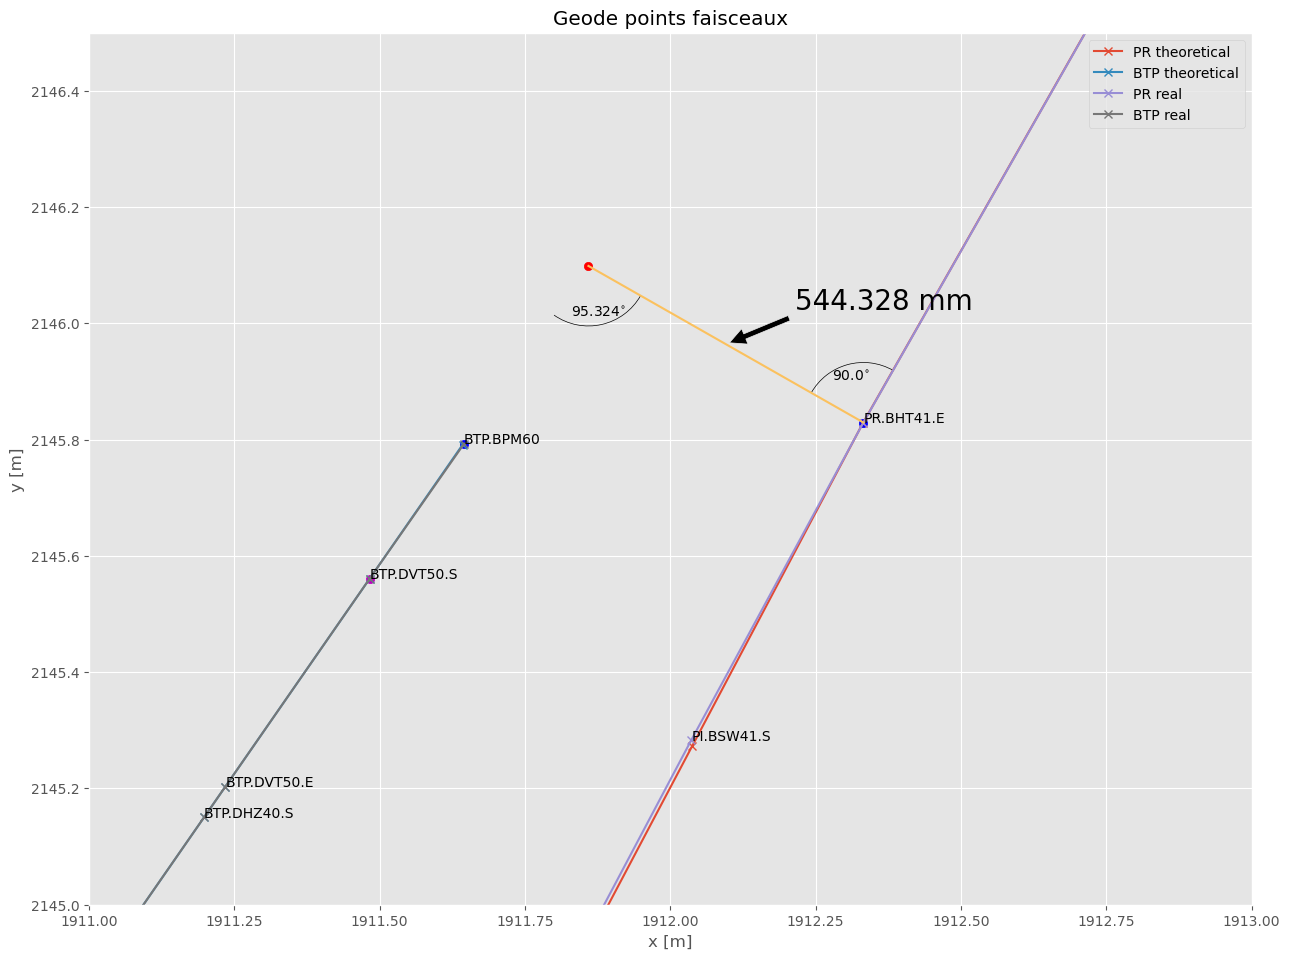

In [99]:
fig, ax = plt.subplots(figsize=(15,15))
plt.title("Geode points faisceaux")

ax.plot(pr.x, pr.y, marker="x", label = "PR theoretical")
ax.plot(btp.x, btp.y, marker="x", label = "BTP theoretical")

ax.plot(pr.x_dev_absolute, pr.y_dev_absolute, marker="x", label = "PR real")
ax.plot(btp.x_dev_absolute, btp.y_dev_absolute, marker="x", label = "BTP real")
ax.scatter(x1,y1, color="m")
ax.scatter(x2,y2, color="b")
ax.scatter(x3,y3, color="r")
ax.scatter(x4,y4, color="b")

x_range3 = np.linspace(x4, x8, num=2)

ax.scatter(x7,y7, color="r")
ax.scatter(x8,y8, color="r")
ax.plot(x_range3, a6*x_range3 + b6)
v_solution3 = [x8-x4,y8-y4]
print (LA.norm(v_solution3))

for i, txt in enumerate(pr.name[pr_range[0]:pr_range[1]]):
    ax.annotate(txt, (pr.x_dev_absolute[pr_range[0]+i], pr.y_dev_absolute[pr_range[0]+i]), xycoords='data', rotation=0)

for i, txt in enumerate(btp.name[btp_range[0]:btp_range[1]]):
    ax.annotate(txt, (btp.x_dev_absolute[btp_range[0]+i], btp.y_dev_absolute[btp_range[0]+i]), xycoords='data', rotation=0)

ax.annotate(f"{round(LA.norm(v_solution3)*1000,3)} mm", xy=(v_solution3[0]/2+x4, v_solution3[1]/2+y4), xycoords='data', xytext=(50, 25), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)

theta4 = np.arccos(np.vdot([x7-x4,y7-y4],[x8-x4,y8-y4])/(LA.norm([x7-x4,y7-y4])*LA.norm([x8-x4,y8-y4])))
angle_MU41_perpendic = AngleAnnotation((x4,y4), (x7, y7), (x8,y8), ax=ax, size=120, text=str(round(theta4*180/np.pi,3))+r"$^{\circ}$", linestyle="-", color="k", text_kw=dict(fontsize=10, color="k"))

theta5 = np.arccos(np.vdot([x4-x8,y4-y8],[x2-x8,y2-y8])/(LA.norm([x4-x8,y4-y8])*LA.norm([x2-x8,y2-y8])))
angle_BTP_perpendic = AngleAnnotation((x8,y8), (x2,y2), (x4, y4), ax=ax, size=120, text=str(round(theta5*180/np.pi,3))+r"$^{\circ}$", linestyle="-", color="k", text_kw=dict(fontsize=10, color="k"))


ax.set_aspect('equal')
ax.set_xlim(1911,1913)
ax.set_ylim(2145,2146.5)
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.legend()
plt.savefig("fig/geode_btp_pr_mu41_zoom_real_points", facecolor='white', transparent=False, dpi = 150, bbox_inches='tight')